## Chapter 3 [Imaging](Ch3-Imaging.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Image Analysis


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes
part of 


## First we import all relvant libraries

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook 
%gui qt


# our blob detectors from the scipy image package
from skimage.feature import blob_dog, blob_log, blob_doh
# Multidimensional Image library
import scipy.ndimage as ndimage

import time
# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
import pyTEMlib.image_tools as it         # Image Processing library
import pyTEM.TEMlib.KinsCat as ks         # Kinematic sCattering Library

# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyTEM version: ',pyTEMlib.__version__)


Populating the interactive namespace from numpy and matplotlib
windows
Using KinsCat library version  0.5  by G.Duscher
Symmetry functions of spglib enabled
pyTEM version:  0.6.2019.5


# Load an atomic resolution image

Look at [CH3-Image-Processing](CH3-Image_Processing.ipynb) for an example


<IPython.core.display.Javascript object>


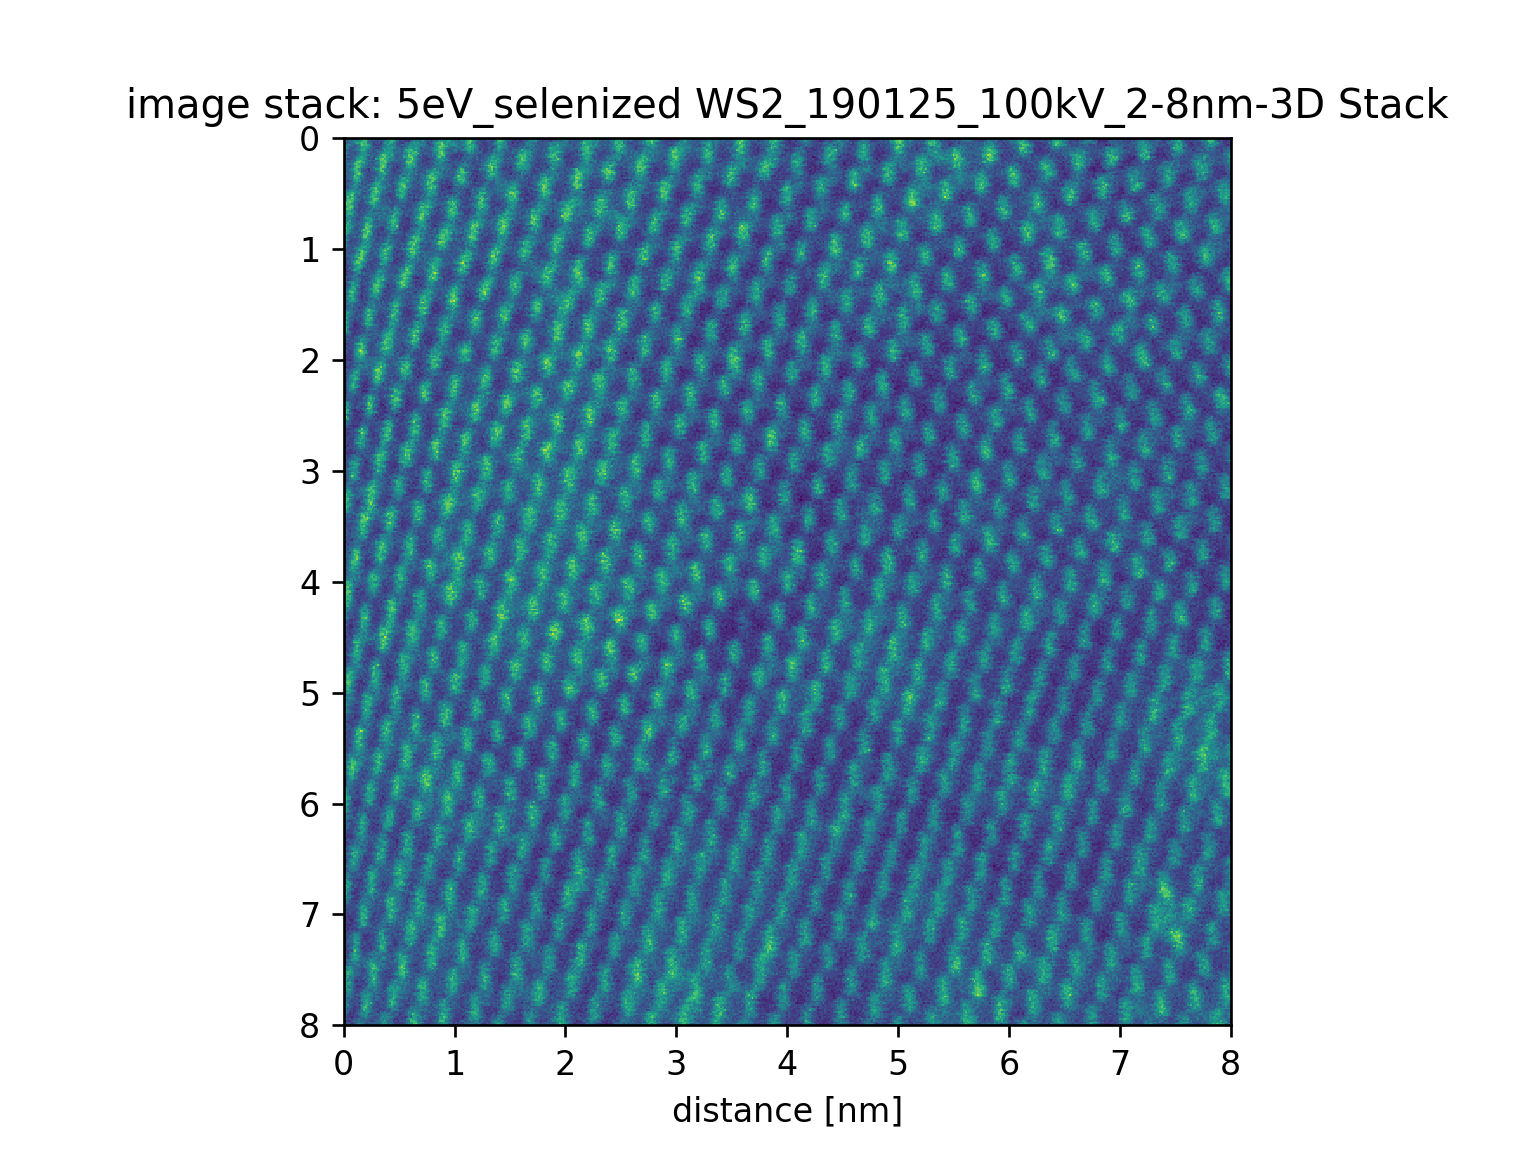

In [2]:
# Load file
#h5_file.close()
h5_file = ft.h5open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

ft.h5_plot(current_channel)


# Previous Analyses

Check for previous analysis

Log_000 includes analysis: Rigid Registration
Log_001 includes analysis: Non-Rigid Registration
Log_002 includes analysis: Atom Positions
Log_003 includes analysis: atom position refinement


<IPython.core.display.Javascript object>


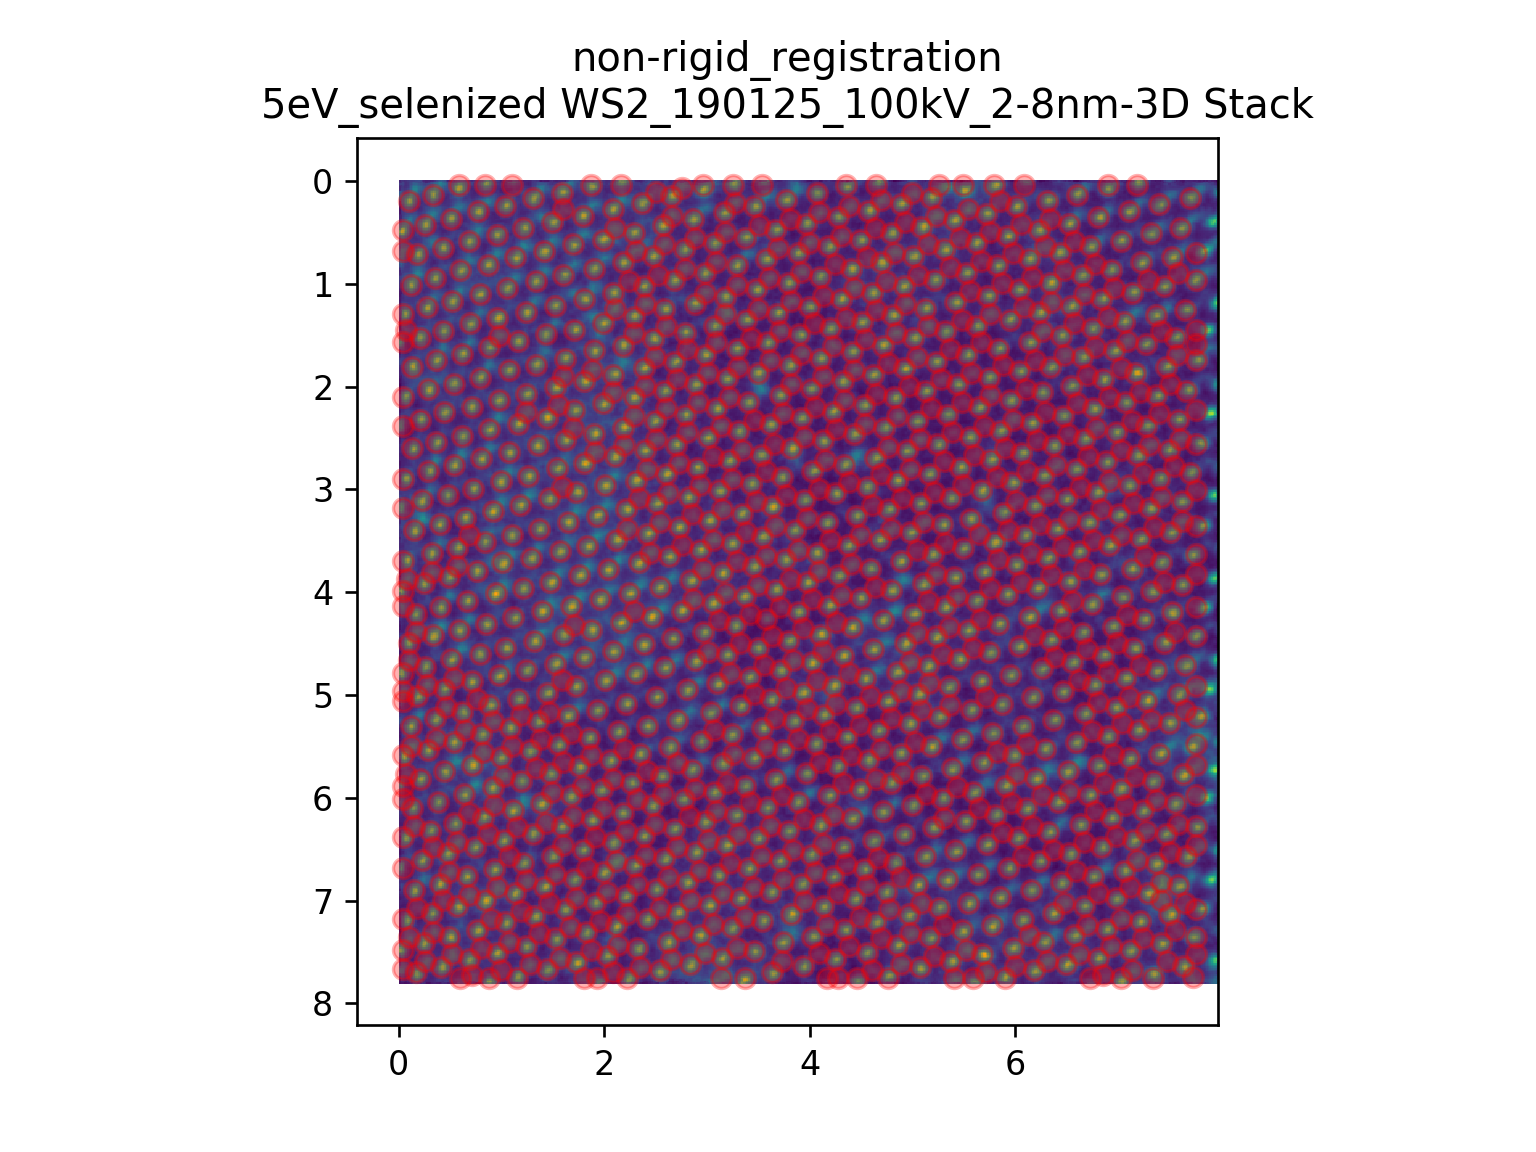

In [3]:
current_channel = h5_file['Measurement_000/Channel_000']

image_channel = None
atom_channel = None
for key in current_channel:
    if 'Log' in key:
        print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")
        if 'Registration' in current_channel[key]['analysis'][()]:
            image_channel = current_channel[key]
        if 'Position' in current_channel[key]['analysis'][()]:
            atom_channel = current_channel[key]
              
if image_channel == None:
    ft.plt_pyUSID(current_channel)
    image_channel = current_channel
    sizeX = current_channel['spatial_size_x'][()]
    sizeY = current_channel['spatial_size_y'][()]
    scaleX = current_channel['spatial_scale_x'][()]
    scaleY = current_channel['spatial_scale_y'][()]
    
    FOV_x = sizeX*scaleX
    FOV_y = sizeY*scaleY
    extent = (0, FOV_X, FOV_y,0)
    data = np.reshape(current_channel['Raw_Data'][:,0],(sizeX,sizeY))
    #data = tags['data']
else:
    plt.figure()
    data = image_channel['data'][()]
    sizeX = image_channel['spatial_size_x'][()]
    sizeY = image_channel['spatial_size_y'][()]
    scaleX = image_channel['spatial_scale_x'][()]
    scaleY = image_channel['spatial_scale_y'][()]
    FOV_x = sizeX*scaleX
    FOV_y = sizeY*scaleY
    extent = (0, image_channel['data'][()].shape[1]* scaleX, image_channel['data'][()].shape[0]* scaleY,0)
plt.title(image_channel['title'][()]+'\n'+current_channel['title'][()])
plt.imshow(data, origin = 'upper',extent = extent)
        
if atom_channel != None:
    plt.scatter(atom_channel['atoms'][:,0]*scaleX,atom_channel['atoms'][:,1]*scaleY, alpha = 0.3, color = 'red')

out_tags = {}


## Fourier Transform of Image and Spot Detection
see [Image Processing](CH2-Image_Precessing.ipynb) for details.

Found 19 reflections


<IPython.core.display.Javascript object>


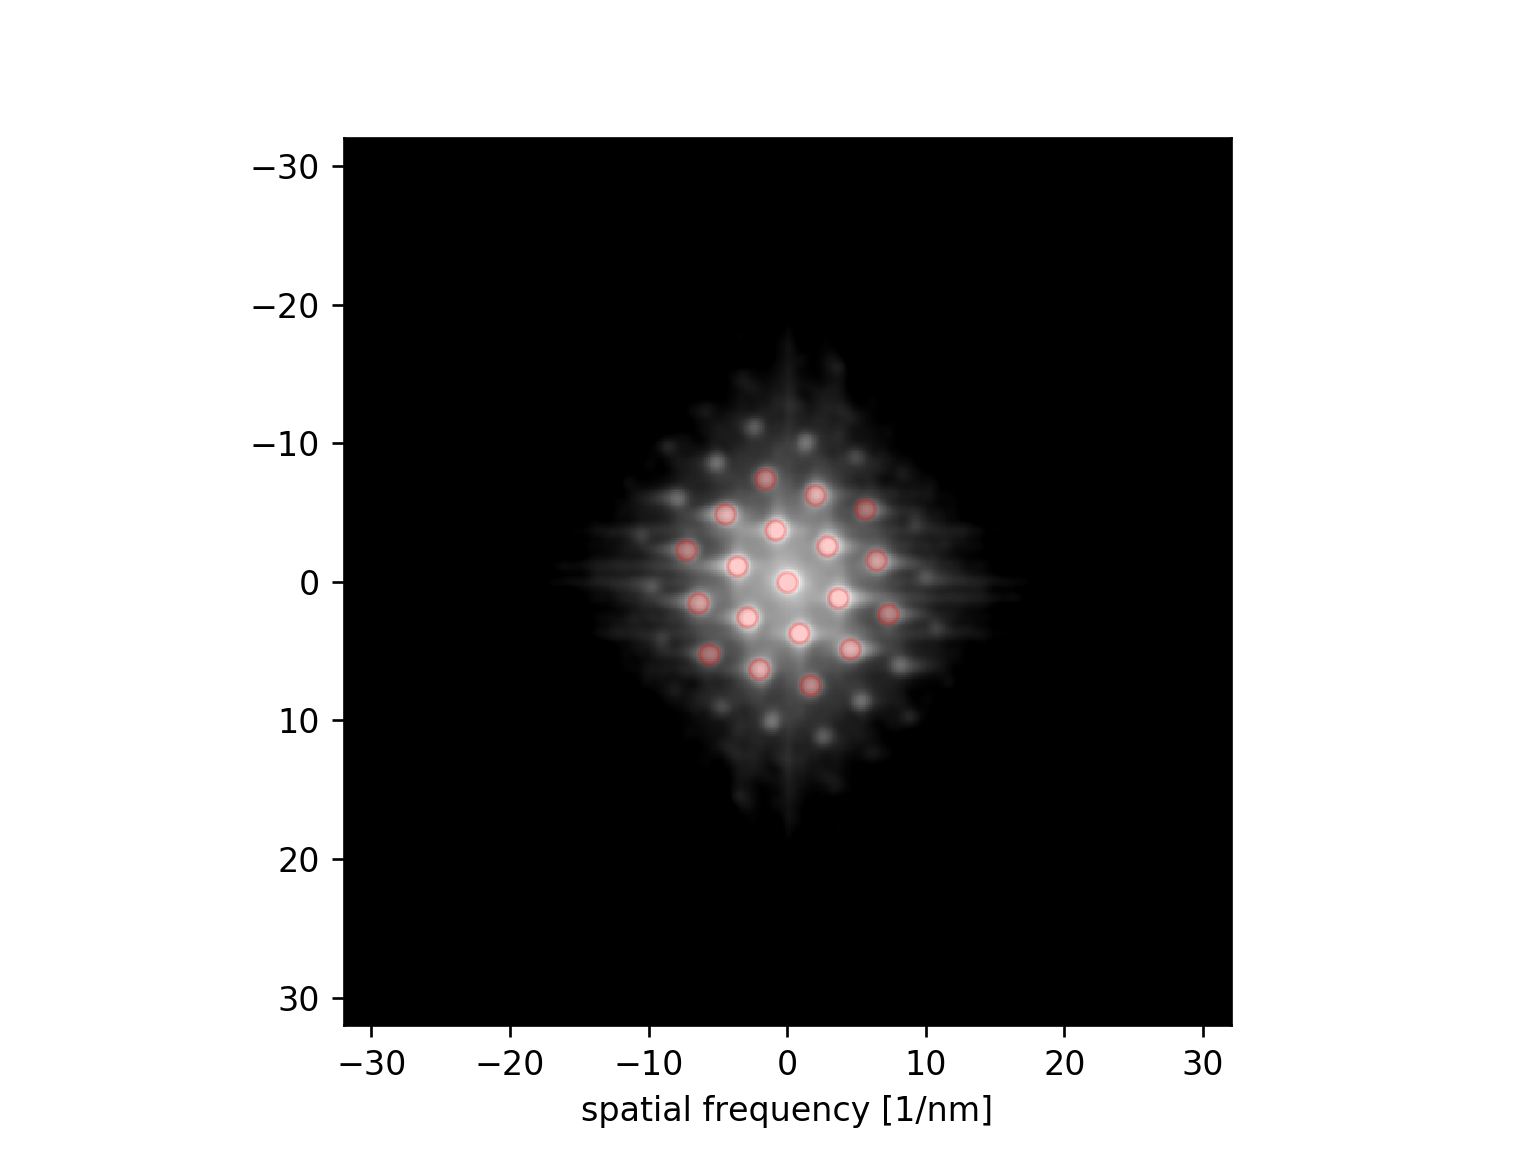

In [4]:
fft_tags = it.power_spectrum(image_channel)
fft_tags['spots'] = it.diffractogram_spots(fft_tags, .02)
fig = plt.figure()
plt.imshow(np.log2(1+fft_tags['data']), extent=np.array(fft_tags['extent']).T, cmap='gray', origin = 'upper',vmin=fft_tags['minimum_intensity'], vmax=fft_tags['maximum_intensity']*.9)
plt.xlabel('spatial frequency [1/nm]');
plt.scatter(fft_tags['spots'][:,0], fft_tags['spots'][:,1], c='red',  alpha = 0.2, label='spots');

## Adaptive Fourier Filtering

We mask the fourier transformed image so that the information can pass through is selected.

The information is in the spots and in the center of the Fourier transformed image,the rest is noise.

Please modify the radius of the mask of the **reflections** and the **low-path** area in the code below and notice the effects on the Fourier filtered image.



<IPython.core.display.Javascript object>


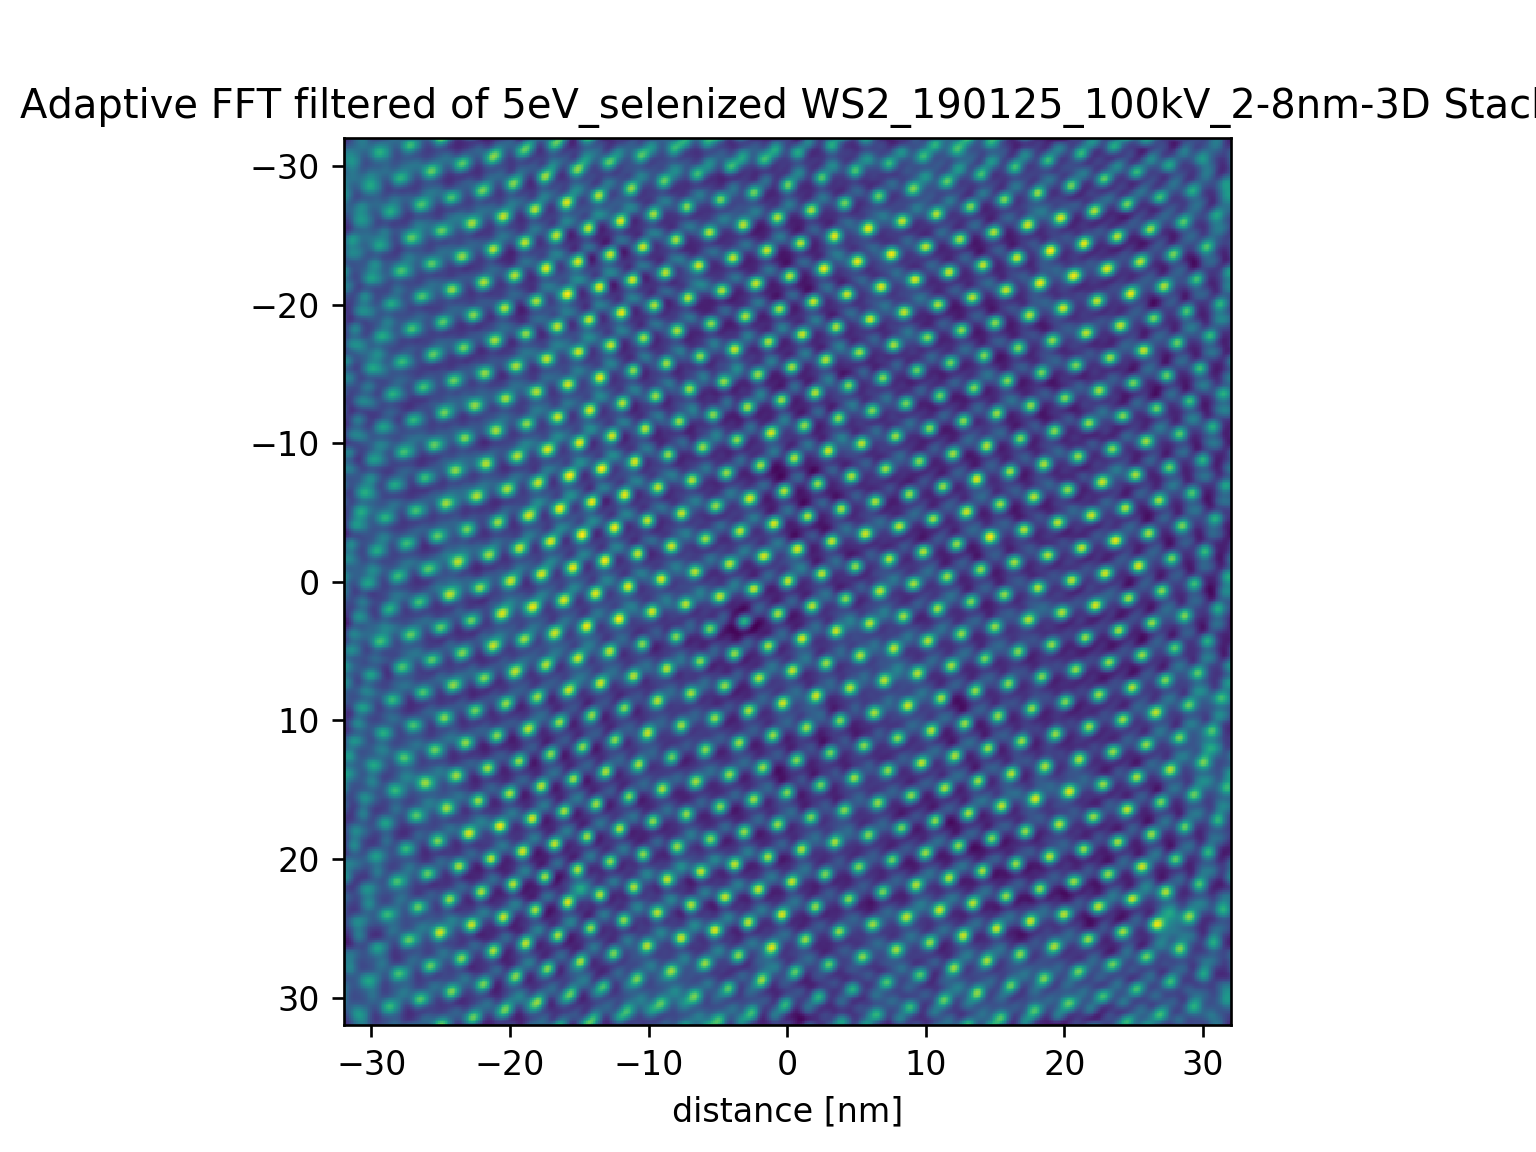

In [5]:
filtered = it.adaptive_Fourier_filter(image_channel['data'][()], fft_tags,reflection_radius = 0.5,low_pass = 3)
plt.figure()
plt.title('Adaptive FFT filtered of '+current_channel['title'][()])
plt.imshow(filtered, extent=fft_tags['extent'], origin = 'upper')
plt.xlabel('distance [nm]');

## Check on filtered images

We don't want to filter anything out that caries information, or at least we want to be aware of that. 
An easy check is to subtract the filtered imag fromt he image and to determine that only noise is left.

Please note that any processing can be easily determined in the Fourier transformed, so be meticulous on reporting what you did to an image.


<IPython.core.display.Javascript object>


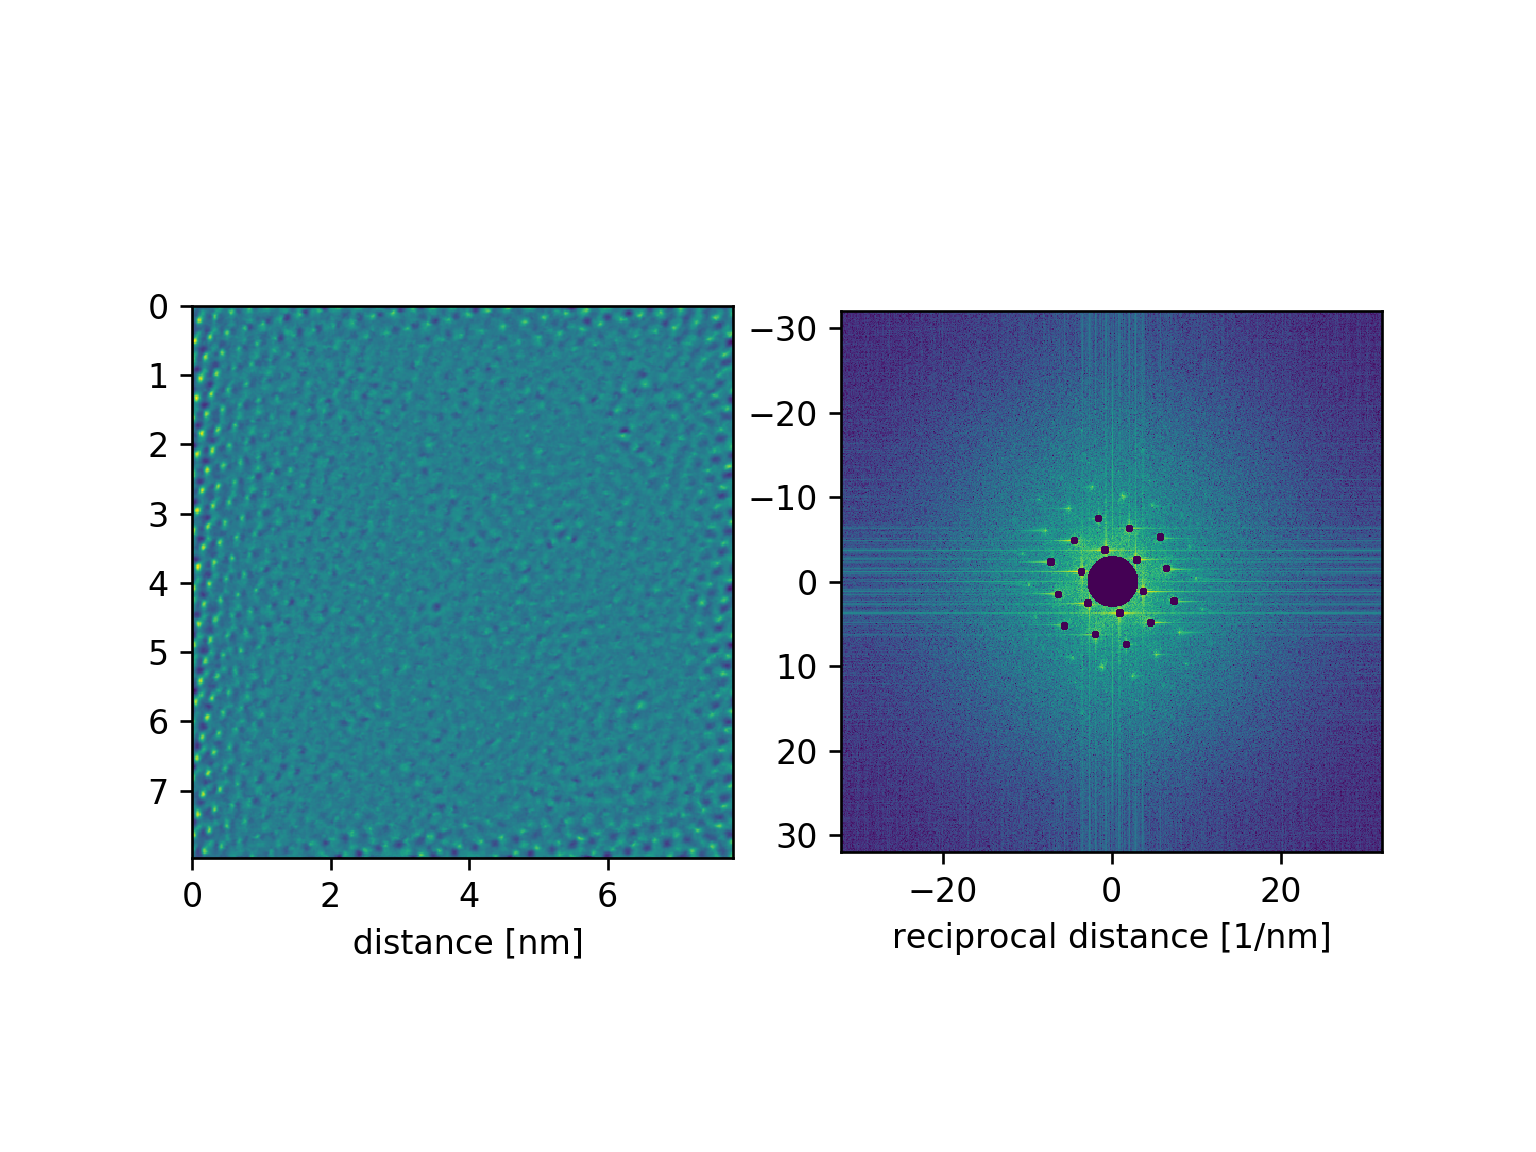

In [6]:
image = image_channel['data'][()]
plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(image-filtered,extent=image_channel['extent'][()], origin = 'upper')
plt.xlabel(' distance [nm]')

ax2 = plt.subplot(1,2,2)
fft_difference = np.fft.fftshift(np.fft.fft2(image-filtered))
ax2.imshow(np.log(1+np.abs(fft_difference)).real,extent=fft_tags['extent'], origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]');

## Rotational Symmetry

In our context of symmetry, we just need to deal with the discrete values of Θ = 2π/n for the angle of rotation.

In two dimensios we have then the rotation matrix:
$$C_{n-fold} = \left[\array{ \cos{( 2\pi/n)} & \sin{( 2\pi/n)}\\ -\sin{( 2\pi/n)} & \cos{ (2\pi/n)}\\}\right]$$

If we subtract all spots from all rotated spots we have a set of distances where for each spot there is minimal distance to the next spot.
If we have a very small distance for each original spot, we have a found rotational symmetry operation.  

In [7]:
it.rotational_symmetry_diffractogram(fft_tags['spots'])
        

[2, 3, 6]

## Reference Crystal

<IPython.core.display.Javascript object>


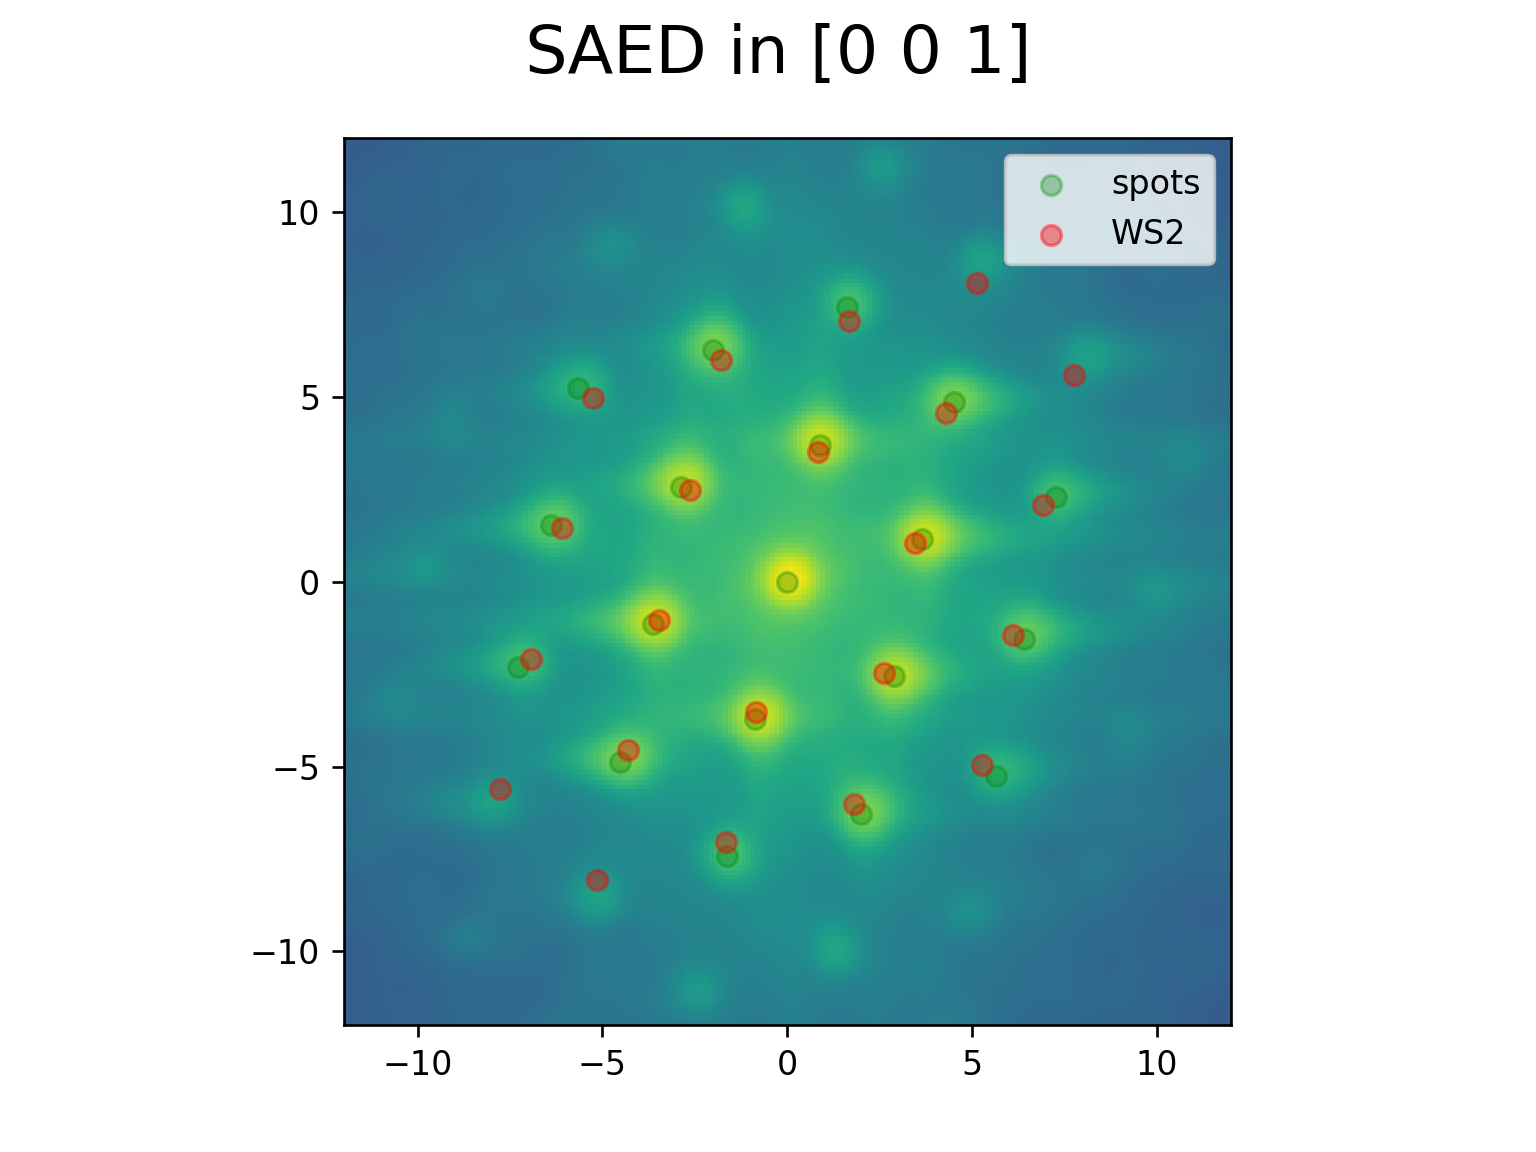

In [26]:
tags_crystal = {}
tags_crystal  = ks.structure_by_name('WS2')

### Define exxperimental parameters:
tags_experiment= {}
tags_experiment['acceleration_voltage_V'] = 200.0 *1000.0 #V
tags_experiment['new_figure'] = False
tags_experiment['plot FOV'] = fft_tags['extent'][0]
tags_experiment['convergence_angle_mrad'] = 0
tags_experiment['zone_hkl'] = np.array([0,0,1])  # incident neares zone axis: defines Laue Zones!!!!
tags_experiment['mistilt']  = np.array([0,0,0])  # mistilt in degrees
tags_experiment['Sg_max'] = .2 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags_experiment['hkl_max'] = 2  # Highest evaluated Miller indices


######################################
# Diffraction Simulation of WS2 #
######################################
tags_crystal.update(tags_experiment)
ks.Kinematic_Scattering(tags_crystal, False)

spots_crystal = tags_crystal['allowed']['g']

crystal_reflections_polar, angles = it.align_crystal_reflections(fft_tags['spots'],[tags_crystal])

fig = plt.figure()
fig.suptitle(' SAED in ' + str(tags_crystal['zone_hkl']), fontsize=20)     
plt.imshow(np.log2(1+fft_tags['data']),extent=fft_tags['extent'], origin = 'upper')

plt.scatter(fft_tags['spots'][:,0], fft_tags['spots'][:,1], c='green',  alpha = 0.3, label='spots');

x, y= it.pol2cart(crystal_reflections_polar[0][0], crystal_reflections_polar[0][1])
reference_spots = np.array(list(zip(x,y)))
plt.scatter(reference_spots[:,0],y, c='red',  alpha = 0.4,label=tags_crystal['crystal_name'])

plt.xlim(-12,12);plt.ylim(-12,12)
plt.legend(loc=1);

<IPython.core.display.Javascript object>


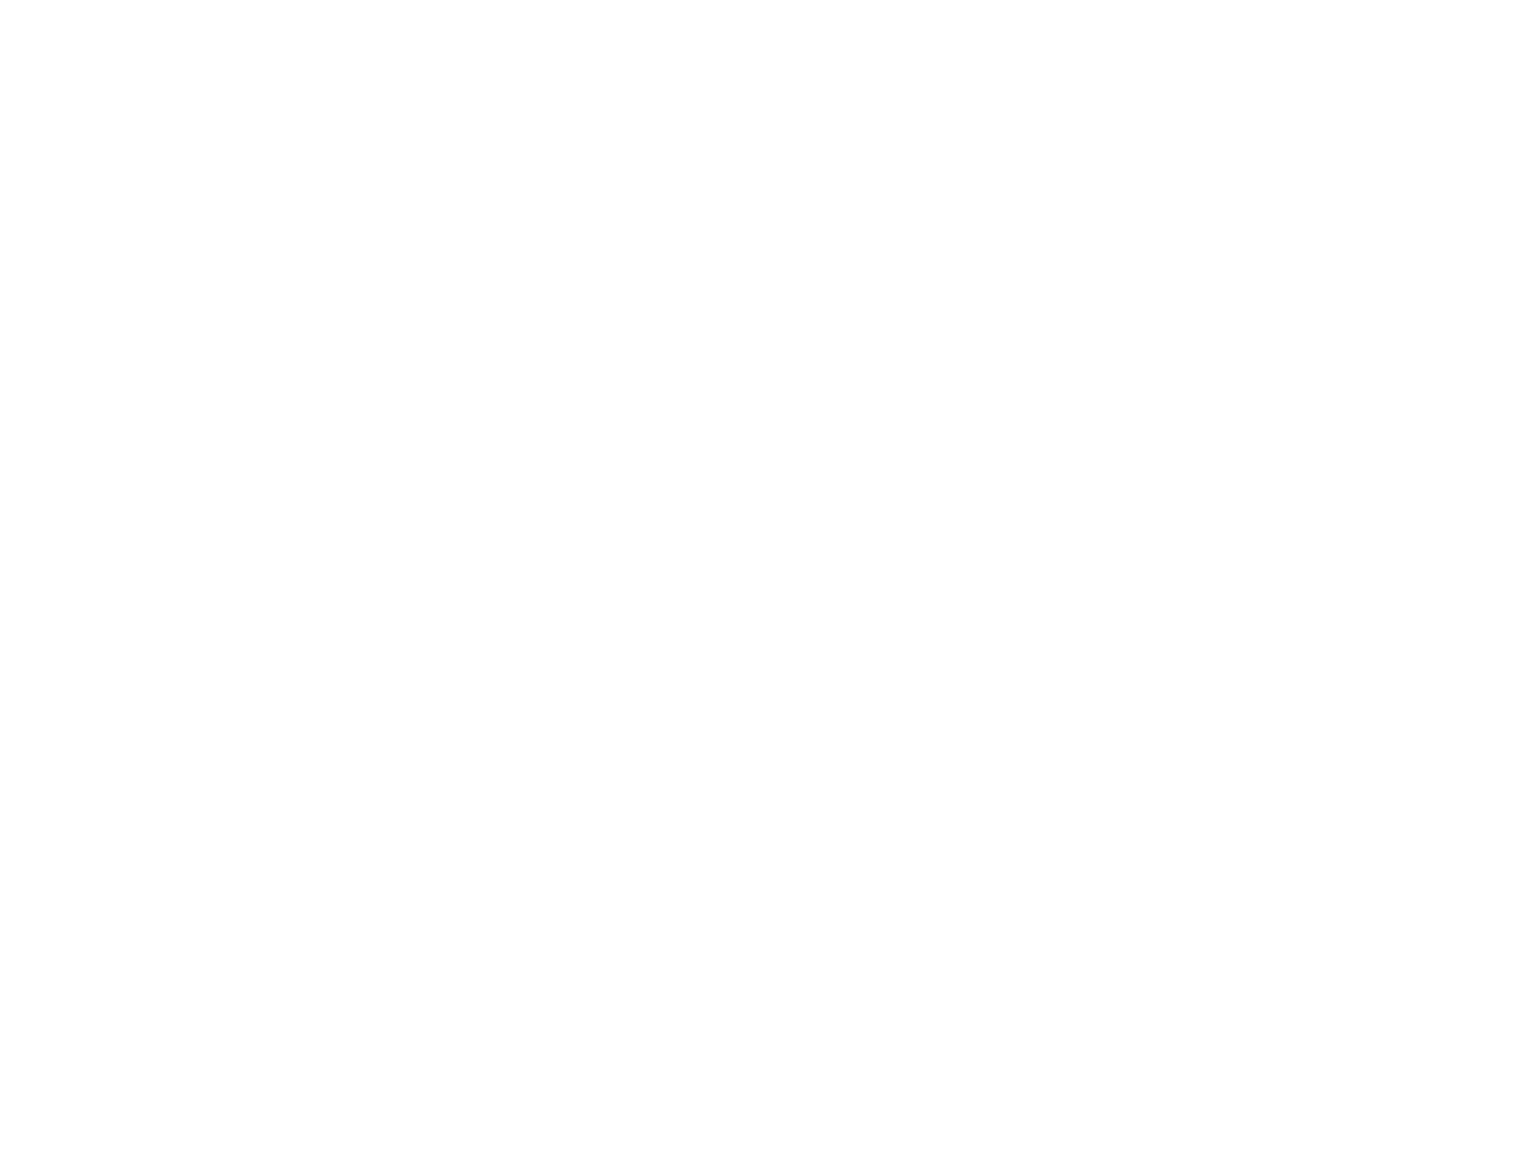

NameError: name 'fft_mag2' is not defined

In [37]:

spots_crystal = tags_crystal['allowed']['g']


resolution = 0.1#nm

plt.figure()
plt.imshow(fft_mag2,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots_crystal[:,0], spots_crystal[:,1], c='Red',  alpha = 0.5, label=tags_crystal['crystal_name']);
plt.scatter(spots[:,0], spots[:,1], c='green',  alpha = 0.5, label='exp.');

plt.legend(loc=1);

## Calibrate Distortions with Reference Crystal

In [30]:
from scipy.optimize import leastsq
def calibrate_imageScale(fft_tags,spots_reference,spots_experiment):
    gx = fft_tags['spatial_scale_x']
    gy = fft_tags['spatial_scale_y']

    dist_reference = np.linalg.norm(spots_reference, axis=1)
    distance_experiment = np.linalg.norm(spots_experiment, axis=1)

    first_reflections = abs(distance_experiment - dist_reference.min()) < .4
    print('Evaluate ', first_reflections.sum(), 'reflections')
    closest_exp_reflections = spots_experiment[first_reflections]

    import scipy.optimize as optimization
    def func(params, xdata, ydata):
        dgx , dgy = params
        return (np.sqrt((xdata*dgx)**2 + (ydata*dgy)**2 ) - dist_reference.min())

    x0 = [1.001,0.999]
    dg, sig = leastsq(func, x0, args=(closest_exp_reflections[:,0], closest_exp_reflections[:,1]))
    return dg


In [35]:
(dgx,dgy) = calibrate_imageScale(fft_tags,reference_spots,fft_tags['spots'])
spots_experiment = fft_tags['spots'][:,:2]*(dgx,dgy)


Evaluate  2 reflections


## Plot Corrected Image and Reference Lattice

<IPython.core.display.Javascript object>


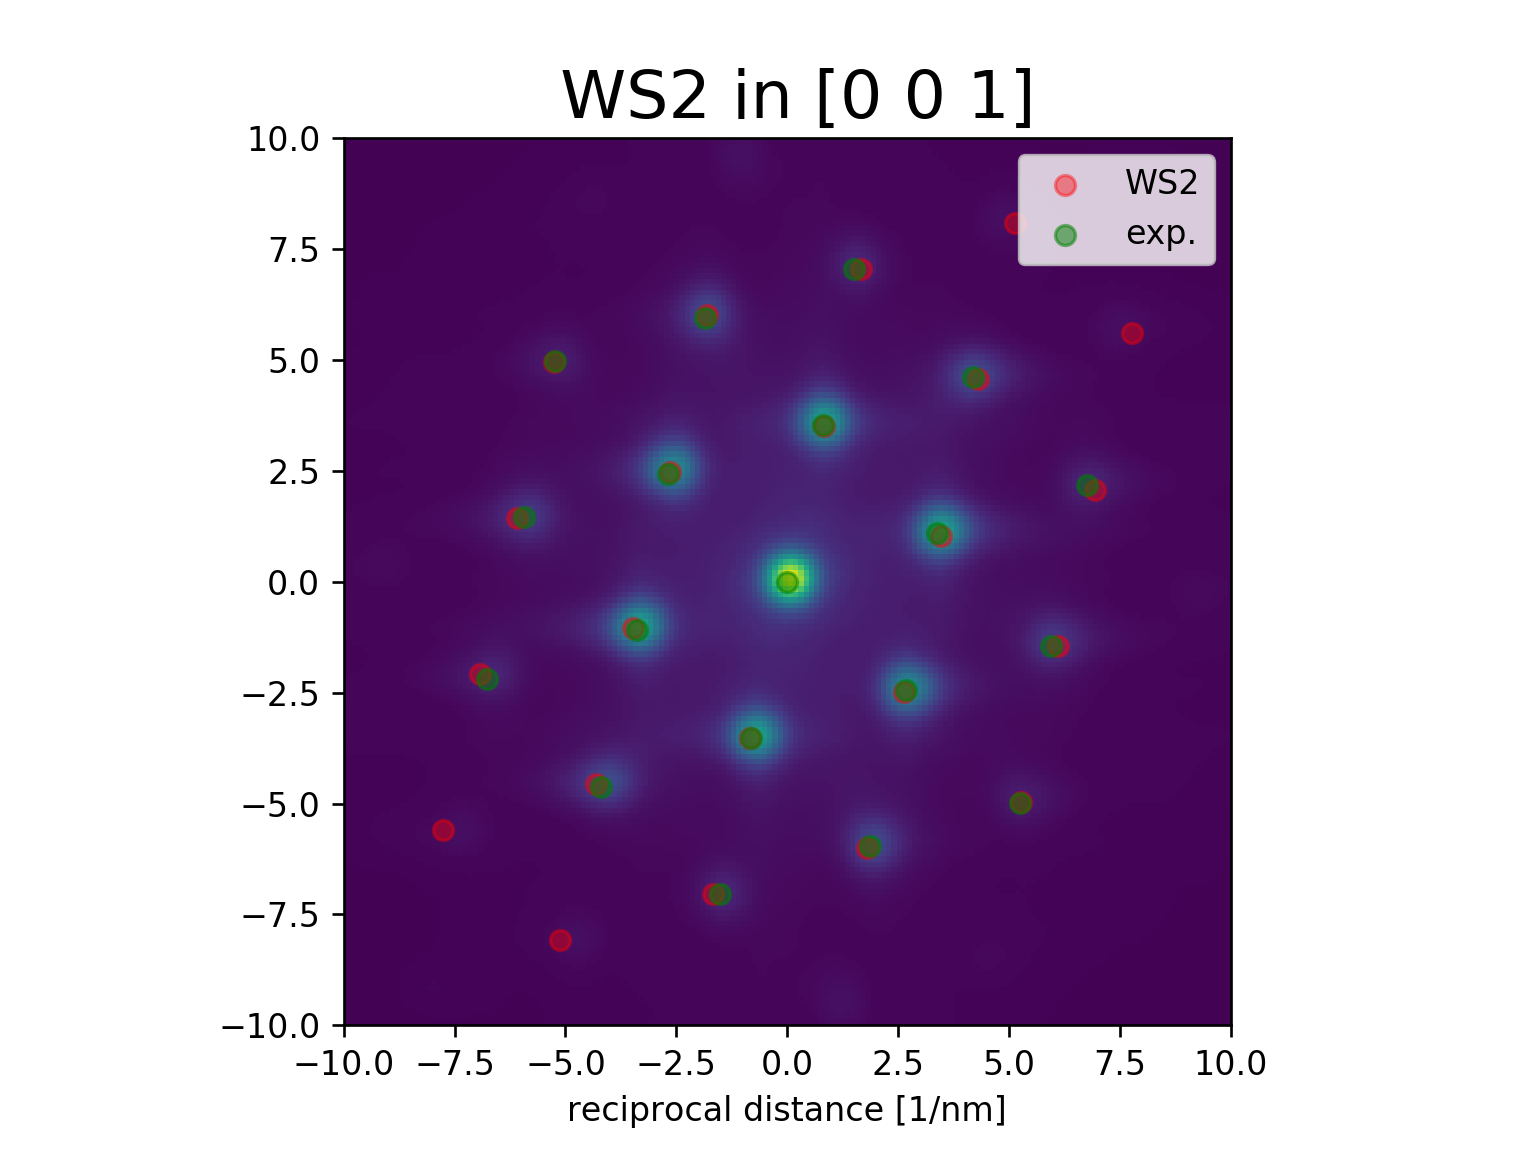

In [44]:
FOV_cor = (0,FOV_x/dgx,FOV_y/dgy,0)
rec_FOV_cor = np.array(fft_tags['extent'])
rec_FOV_cor[:2] = rec_FOV_cor[:2]*dgx
rec_FOV_cor[2:] = rec_FOV_cor[2:]*dgy
plt.figure()
plt.title(f" {tags_crystal['crystal_name']} in {str(tags_crystal['zone_hkl'])}", fontsize=20)     

plt.imshow(fft_tags['data'],extent=rec_FOV_cor, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')

plt.scatter(x,y, c='red',  alpha = 0.4,label=tags_crystal['crystal_name'])
plt.scatter(spots_experiment[:,0], spots_experiment[:,1], c='green',  alpha = 0.5, label='exp.');


plt.xlim(-10,10)
plt.ylim(-10,10)
plt.legend(loc=1);


 Rotated WSe2 SAD by 46.7°


<IPython.core.display.Javascript object>


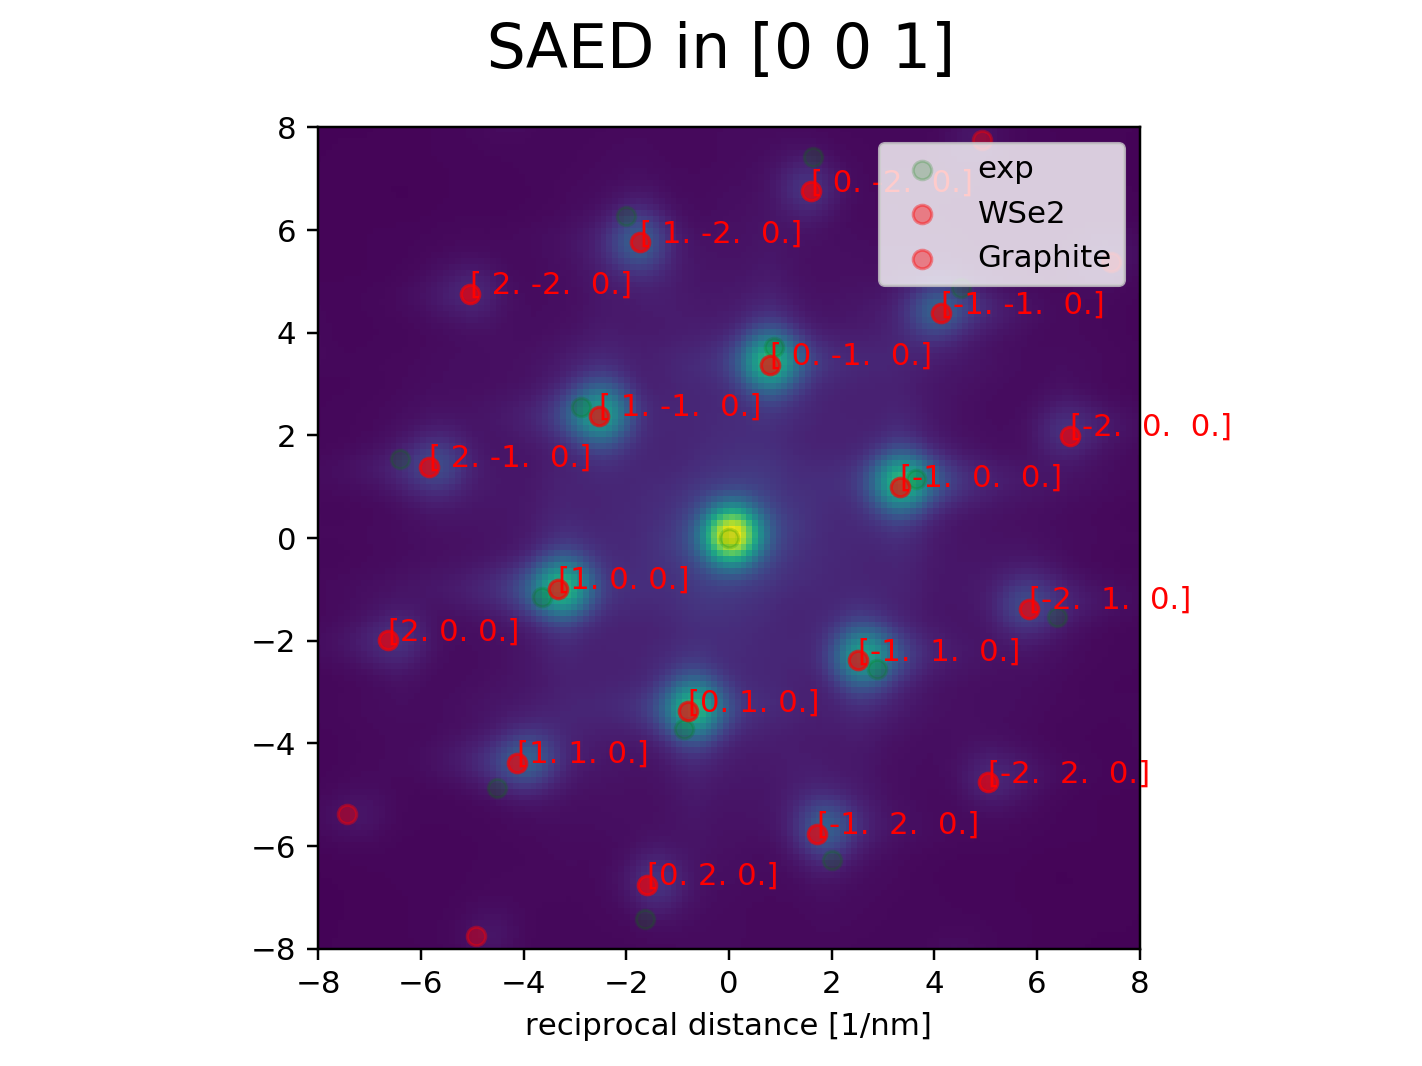

C:\Users\gduscher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


In [73]:
## Transfer everything to polar coordinates 
crystal_r, crystal_phi, crystal_indices = xy2polar(spots_crystal) #sorted by r and phi , only positive angles
exp_r, exp_phi = cart2pol(spots) # just in polar coordinates

resolution = 1/exp_r.max()
visible_crystal = crystal_r < 1/resolution


angleI = np.argmin(np.abs(exp_r-graphite_r[0]) )
angle = exp_phi[angleI] - crystal_phi[0] ## Determine rotation angle

crystal_phi = crystal_phi + angle # rotation
print(f" Rotated {tags_crystal['crystal_name']} SAD by {np.degrees(angle):.1f}°")



fig = plt.figure()
fig.suptitle(' SAED in ' + str(tags_Graphite['zone_hkl']), fontsize=20)     
plt.imshow(fft_mag2,extent=rev_FOV_cor, origin = 'upper')

x, y= pol2cart(exp_r, exp_phi)
plt.scatter(x,y, c='green',  alpha = 0.2,label='exp')

plt.xlabel('reciprocal distance [1/nm]')
x, y= pol2cart(graphite_r, graphite_phi)
plt.scatter(x,y, c='red',  alpha = 0.4,label=tags_crystal['crystal_name'])


x, y= pol2cart(crystal_r[visible_crystal], crystal_phi[visible_crystal])
plt.scatter(x,y, c='red',  alpha = 0.4,label='Graphite')

for i in range(len(crystal_r)):
    if visible_crystal[i]:
        plt.text(x[i],y[i], tags_crystal['allowed']['hkl'][crystal_indices[i]],color='red')




plt.xlim(-8,8);plt.ylim(-8,8)
plt.legend(loc=1);


## Plot Histograms of Distances

In [75]:
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates


def cartesian2polar(x, y, grid, r, t, order=3):

    R,T = np.meshgrid(r, t)

    new_x = R*np.cos(T)
    new_y = R*np.sin(T)

    ix = interp1d(x, np.arange(len(x)))
    iy = interp1d(y, np.arange(len(y)))

    new_ix = ix(new_x.ravel())
    new_iy = iy(new_y.ravel())

    
    return map_coordinates(grid, np.array([new_ix, new_iy]),
                            order=order).reshape(new_x.shape)

def warp(diff):
    # Define original polar grid
    nx = diff.shape[0]
    ny = diff.shape[1]

    x = np.linspace(1, nx, nx, endpoint = True)-center[1]
    y = np.linspace(1, ny, ny, endpoint = True)-center[0]
    z = diff

    # Define new polar grid
    nr = min([center[0], center[1], diff.shape[0]-center[0], diff.shape[1]-center[1]])-1
    nt = 360*3


    r = np.linspace(1, nr, nr)
    t = np.linspace(0., np.pi, nt, endpoint = False)
    return cartesian2polar(x,y, z, r, t, order=3).T

In [76]:
polar_projection = warp(fft_mag)
below_zero = polar_projection<0.
polar_projection[below_zero]=0.

# Sum over all angles (axis 1)
profile = polar_projection.sum(axis=1)


k =np.linspace(1,len(profile),len(profile))*rev_scale_x

Cs = 2.2
defocus = -184 # underfocus is negative
waveLength = ks.get_waveLength(200*1e3) # in nm
def calculateScherzer(waveLength, Cs):
    # Calculate the Scherzer defocus. Cs is in mm, lambda is in nm
    # Everything is trasnfered to m
    #The returned value is in nm
    Cs=Cs*1e-3 # now in m
    scherzer=-1.155*(Cs*waveLength*1e-9)**0.5 # in m
    scherzer=scherzer*1e9 # convert to nm
    return scherzer

scherzer =calculateScherzer(waveLength, Cs)

print(f'Scherzer defocus is {scherzer:.1f} nm')

def calculateCTF(waveLength, Cs, defocus,k3):
    # everything in nm
    Cs=Cs*10**6
    ctf=np.sin(np.pi*defocus*waveLength*k**2+0.5*np.pi*Cs*waveLength**3*k**4)
    return ctf
ctf = calculateCTF(waveLength, Cs, defocus,k)


fig = plt.figure()
plt.hist(exp_r,45,facecolor='green', alpha=0.75, label='experiment')
plt.hist(graphite_r,200,facecolor='red', alpha=0.75, label='graphite')
plt.xlim(0,exp_r.max()*1.05)

plt.hist(ZnO_r,200,facecolor='blue', alpha=0.75, label='ZnO')
plt.plot(k,profile/profile.max()*5000,c='orange',label='diffractogram' );
plt.plot(k,np.abs(ctf)*3, label = f'ctf df = {defocus:.1f}nm')
#plt.hist(np.linalg.norm(p_ZnO, axis=1),200,facecolor='orange', alpha=0.75, label='hexagonal ZnO')
plt.legend()
plt.xlabel('reciprocal lattice vector [1/nm]')
plt.ylabel('number of reflections')

plt.ylim(0,9)

plt.show()

ValueError: A value in x_new is above the interpolation range.

## Another Image
Go back to [Load an atomic resolution image](#Load-an-atomic-resolution-image)

Try the same procedure with image **p1-hr4-ZnOonGraphite.dm3** in the TEMdata directory, which is taken with a different defocus (which one?)

In [77]:
# The x and y size of the image are stored in the 'axis' keyword of the dicyionary
print(image_tags['axis'].keys())
print(image_tags['axis']['0'])

# The scale has to be recalculated
dx = image_tags['axis']['0']['scale']/ dgx
dy = image_tags['axis']['1']['scale']/ dgy

print(f"pixel size x: {dx*1000:.2f}pm, y: {dy*1000.:.2f}pm , nominal {image_tags['pixel_size']*1000:.2f}pm")

print('error x:{0:.2f}%, y:{1:.2f}%'.format(abs(dx- image_tags['pixel_size'] )/image_tags['pixel_size']*100,
                                    abs(dy- image_tags['pixel_size'] )/image_tags['pixel_size']*100))

NameError: name 'image_tags' is not defined

## Conclusion:
We see that we can calibrate an image with sub pm precission if the lattice of a reference crystal is resolved.
The original image scale and distortion was accurate within less than 2%. A quite respectable result, if one takes into account that the objective stigmators and the objecitve focus vary from image to image. These electron optic values will change the magnification of course. 

## Back: [Contrast Transfer Function](CTF.ipynb)
## Next: [Image Analysis2](ImageAnalysis3.ipynb)
## Chapter 3: [Imaging](Imaging.ipynb)
## List of Content: [Front](_MSE672-IntroToTEM.ipynb)